In [1]:
# Libraries
from nilearn import datasets
# from nideconv.utils import roi
import pandas as pd
from nilearn import plotting
import nibabel as nib
import nilearn
import matplotlib.pyplot as plt
import nilearn.input_data

In [4]:
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas.labels=atlas.labels.tolist()
atlas_labels = [label.decode('utf-8') for label in atlas.labels]
atlas_filename=atlas.maps
# Load the atlas image using nibabel
atlas_img = nib.load(atlas.maps)

# Define the output file name
output_file = 'atlas_Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz'

# Save the atlas image as a .nii.gz file
nib.save(atlas_img, output_file)


In [16]:

coReg='sub-126BPCP021001_ses-1_task-rest_coReg2atlas_flirt.nii.gz'
coreg_ref='sub-126BPCP021001_ses-1_task-rest_desc-coreg_boldref.nii.gz'
confounds_fn = 'sub-126BPCP021001_ses-1_task-rest_desc-confounds_timeseries.tsv'
# We need to load the confounds and fill nas
confounds = pd.read_table(confounds_fn).fillna(method='bfill')
atlas='tpl-MNI152NLin2009cAsym_res-01_atlas-Schaefer2018_desc-100Parcels17Networks_dseg.nii.gz'
atlas2T1w='/home/ubuntu/Desktop/Thesis/overlap/overlappingTest/atlas2T1w.nii.gz'
atlas2BoldinT1w='/home/ubuntu/Desktop/Thesis/overlap/overlappingTest/parcel2BoldmaskinT1maskspace.nii.gz'

In [17]:
atlas_img=img=nib.load(atlas)
atlas2T1w_img=img=nib.load(atlas2T1w)
atlas2BoldinT1w_img=img=nib.load(atlas2BoldinT1w)
coReg_img=nib.load(coReg).get_fdata()
fmri_img=nib.load('/home/ubuntu/Desktop/Thesis/overlap/sub-126BPCP021001_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')


In [18]:
# f_img=nib.load('/home/ubuntu/Desktop/Thesis/convert/Nifti/sub-101026/ses-1/func/sub-101026_ses-1_task-rest_bold.nii.gz')
# f_img_data = f_img.get_fdata()
# print(f_img_data.shape)
# print(f_img.header.get_zooms() )
# print(f_img.header['pixdim'])

In [19]:
import numpy as np

# Check if any voxel equals 10T
if np.any(nilearn.image.get_data(atlas2BoldinT1w_img)== 98):
    print("There is at least one voxel with a value of 10 in the atlas.")
else:
    print("No voxel has a value of 10 in the atlas.")

There is at least one voxel with a value of 10 in the atlas.


In [20]:
# Initialize the NiftiLabelsMasker with some standard options for preprocessing
masker_atlas2Bold = nilearn.input_data.NiftiLabelsMasker( atlas2BoldinT1w_img, standardize=True, smoothing_fwhm=6,memory='nilearn_cache', verbose=5)

time_series_boldmask = masker_atlas2Bold.fit_transform(fmri_img, confounds)


[NiftiLabelsMasker.wrapped] loading data from Nifti1Image('/home/ubuntu/Desktop/Thesis/overlap/overlappingTest/parcel2BoldmaskinT1maskspace.nii.gz')
Resampling labels
[Memory]1.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [21]:
# Initialize the NiftiLabelsMasker with some standard options for preprocessing
masker_atlas2T1w = nilearn.input_data.NiftiLabelsMasker( atlas2T1w_img, standardize=True, smoothing_fwhm=6,memory='nilearn_cache', verbose=5)

time_series_atlasmask = masker_atlas2T1w.fit_transform(fmri_img, confounds)

[NiftiLabelsMasker.wrapped] loading data from Nifti1Image('/home/ubuntu/Desktop/Thesis/overlap/overlappingTest/atlas2T1w.nii.gz')
Resampling labels
[Memory]1.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [22]:
print(time_series_atlasmask.shape )
print(time_series_boldmask.shape )
import pandas as pd

# Define the path to your TSV file
tsv_file_path = "/home/ubuntu/Desktop/Thesis/overlap/tpl-MNI152NLin2009cAsym_atlas-Schaefer2018_desc-100Parcels7Networks_dseg.tsv"

# Read the TSV file into a DataFrame
atlas_data = pd.read_csv(tsv_file_path, delimiter='\t')
atlas_labels=atlas_data['name'].tolist()
print(type(atlas_labels))

(420, 100)
(420, 100)
<class 'list'>


In [23]:
# Define region label you want to compare (example: label index 10)
region_label = 10

# Get data from atlas images
atlas1_data = atlas2BoldinT1w_img.get_fdata()
atlas2_data = atlas2T1w_img.get_fdata()

# Create binary masks for the given region
mask1 = (atlas1_data == region_label).astype(int)
mask2 = (atlas2_data == region_label).astype(int)

(224, 256, 256)


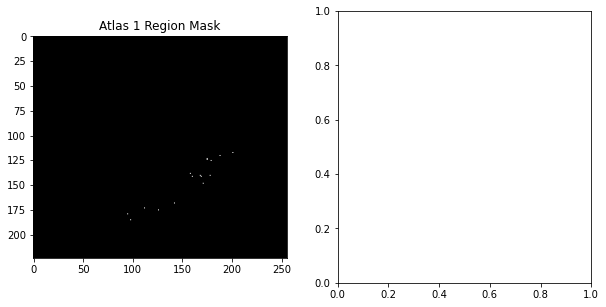

In [24]:
mask = (atlas2_data == 75).astype(int)
import matplotlib.pyplot as plt
print(mask.shape)
# Plot the binary masks
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mask[:, :, mask.shape[2] // 2], cmap='gray')
axes[0].set_title('Atlas 1 Region Mask')

plt.show()


In [25]:
# Function to compute Dice coefficient
def dice_coefficient(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    sum_masks = np.sum(mask1) + np.sum(mask2)
    if sum_masks == 0:
        return 1.0
    return 2. * intersection / sum_masks

In [26]:
# Compute Dice coefficient for the given region
import numpy as np
dice_score = dice_coefficient(mask1, mask2)
print(f'Dice Coefficient for region {region_label}: {dice_score}')


Dice Coefficient for region 10: 0.5241672453338384


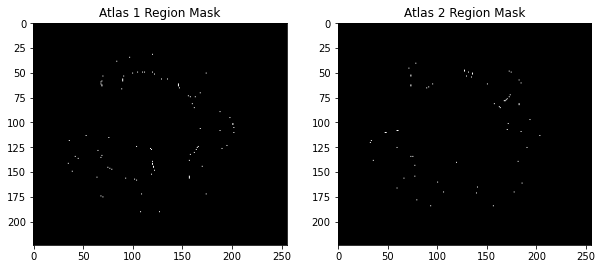

In [27]:
import matplotlib.pyplot as plt

# Plot the binary masks
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mask1[:, :, mask1.shape[2] // 2], cmap='gray')
axes[0].set_title('Atlas 1 Region Mask')

axes[1].imshow(mask2[:, :, mask2.shape[2] // 2], cmap='gray')
axes[1].set_title('Atlas 2 Region Mask')

plt.show()


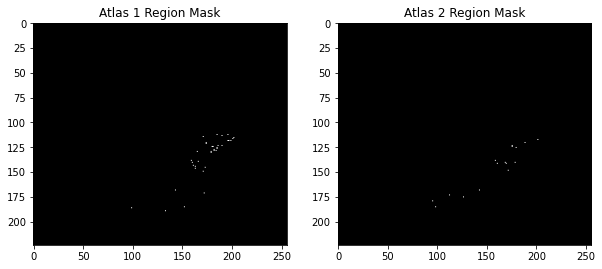

In [28]:
# Plot the binary masks
mask3 = (atlas1_data == 75).astype(int)
mask4 = (atlas2_data == 75).astype(int)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mask3[:, :, mask3.shape[2] // 2], cmap='gray')
axes[0].set_title('Atlas 1 Region Mask')

axes[1].imshow(mask4[:, :, mask4.shape[2] // 2], cmap='gray')
axes[1].set_title('Atlas 2 Region Mask')

plt.show()


In [28]:
atlas1 = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas1_img = nib.load(atlas1.maps)
region_label = 10

atlas1_data = atlas1_img.get_fdata()
mask1 = (aa== region_label).astype(int)


In [42]:

# Initialize the NiftiLabelsMasker with some standard options for preprocessing
import nilearn.input_data

masker=nilearn.input_data.NiftiLabelsMasker(atlas2BoldinT1w_img, standardize=True, smoothing_fwhm=6,memory='nilearn_cache', verbose=5)

In [43]:
atlas2BoldinT1w_img

/home/ubuntu/.local/lib/python3.10/site-packages/nilearn/plotting/img_plotting.py:572: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  img = new_img_like(roi_img, data, affine=roi_img.affine)


KeyboardInterrupt: 

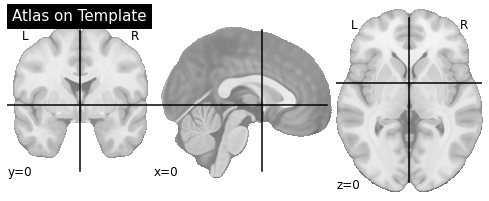

In [27]:


# Display the atlas overlaid on the template
plotting.plot_roi(atlas2T1w_img, title="Atlas on Template", display_mode='ortho',view_type="contours") #cut_coords=(0, 0, 0)

plotting.show()

In [7]:
# We only want to include a subset of confounds
confounds_to_include = ['global_signal', 'csf',
                        'white_matter', 'trans_x', 'trans_y',
                        'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x_power2',
                        'trans_y_power2', 'trans_z_power2', 'rot_x_power2', 'rot_y_power2', 'rot_z_power2']
confounds = confounds[confounds_to_include]



In [8]:
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
atlas


Dataset created in /home/ubuntu/nilearn_data/schaefer_2018



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


{'maps': '/home/ubuntu/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
 'labels': array([b'7Networks_LH_Vis_1', b'7Networks_LH_Vis_2',
        b'7Networks_LH_Vis_3', b'7Networks_LH_Vis_4',
        b'7Networks_LH_Vis_5', b'7Networks_LH_Vis_6',
        b'7Networks_LH_Vis_7', b'7Networks_LH_Vis_8',
        b'7Networks_LH_Vis_9', b'7Networks_LH_SomMot_1',
        b'7Networks_LH_SomMot_2', b'7Networks_LH_SomMot_3',
        b'7Networks_LH_SomMot_4', b'7Networks_LH_SomMot_5',
        b'7Networks_LH_SomMot_6', b'7Networks_LH_DorsAttn_Post_1',
        b'7Networks_LH_DorsAttn_Post_2', b'7Networks_LH_DorsAttn_Post_3',
        b'7Networks_LH_DorsAttn_Post_4', b'7Networks_LH_DorsAttn_Post_5',
        b'7Networks_LH_DorsAttn_Post_6', b'7Networks_LH_DorsAttn_PrCv_1',
        b'7Networks_LH_DorsAttn_FEF_1',
        b'7Networks_LH_SalVentAttn_ParOper_1',
        b'7Networks_LH_SalVentAttn_FrOperIns_1',
        b'7Networks_LH_SalVentAttn_FrOperIns_2',
        b'

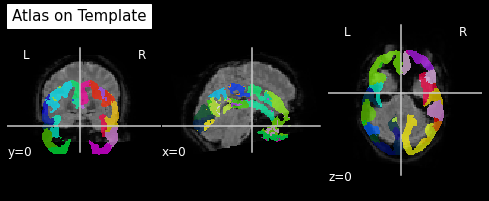

In [9]:
coreg_ref_img=nib.load(coReg)
# Load your atlas
#atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-2mm')
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)

# Display the atlas overlaid on the template
plotting.plot_roi(atlas.maps, bg_img=coreg_ref, title="Atlas on Template", display_mode='ortho', cut_coords=(0, 0, 0))
plotting.show()

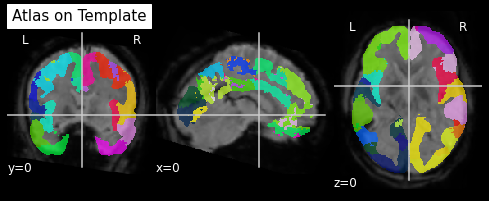

In [10]:
coReg=nib.load(coReg)
# Load your atlas
#atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-2mm')
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)

# Display the atlas overlaid on the template
plotting.plot_roi(atlas.maps, bg_img=coReg, title="Atlas on Template", display_mode='ortho', cut_coords=(0, 0, 0))
plotting.show()

In [15]:
atlas_img=nib.load(atlas.maps)
atlas_img
# Save the new NIfTI image to a file
new_image_path = '/home/ubuntu/Desktop/Thesis/overlap/atlas.nii.gz'
atlas_img.to_filename(new_image_path)

In [25]:
from nilearn.image import resample_to_img
from sklearn.metrics import jaccard_score

# Resample atlas to template
# atlas_resampled = resample_to_img(atlas.maps, coReg)

# Load data from both images
atlas_data = atlas_img.get_fdata().astype(bool).flatten()
template_data = (template_img.get_fdata() > 0).astype(bool).flatten()  # Assuming template is binary

# Calculate Jaccard similarity index (equivalent to Dice coefficient for binary data)
overlap = jaccard_score(atlas_data, template_data)
print(f'Dice Coefficient: {2 * overlap / (1 + overlap)}')


Dice Coefficient: 0.3147569811702167


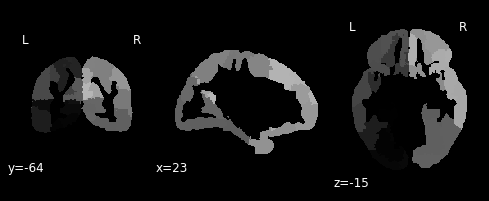

In [18]:
plot = nilearn.plotting.plot_anat(atlas_img, cut_coords=(23,-64,-15),draw_cross=False)

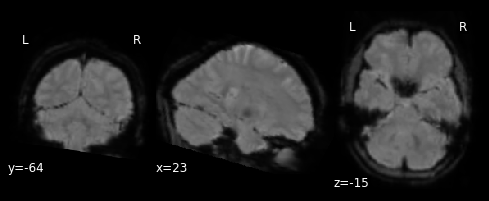

In [19]:
plot = nilearn.plotting.plot_anat(coreg_ref_img, cut_coords=(23,-64,-15),draw_cross=False)

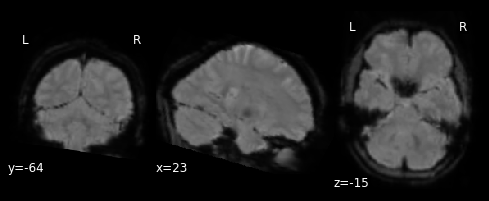

In [20]:
plot = nilearn.plotting.plot_anat(coreg_ref_img, cut_coords=(23,-64,-15),draw_cross=False)

In [10]:
import nilearn
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker

In [11]:
atlas.labels=atlas.labels.tolist()
atlas_labels = [label.decode('utf-8') for label in atlas.labels]
atlas_labels

['7Networks_LH_Vis_1',
 '7Networks_LH_Vis_2',
 '7Networks_LH_Vis_3',
 '7Networks_LH_Vis_4',
 '7Networks_LH_Vis_5',
 '7Networks_LH_Vis_6',
 '7Networks_LH_Vis_7',
 '7Networks_LH_Vis_8',
 '7Networks_LH_Vis_9',
 '7Networks_LH_SomMot_1',
 '7Networks_LH_SomMot_2',
 '7Networks_LH_SomMot_3',
 '7Networks_LH_SomMot_4',
 '7Networks_LH_SomMot_5',
 '7Networks_LH_SomMot_6',
 '7Networks_LH_DorsAttn_Post_1',
 '7Networks_LH_DorsAttn_Post_2',
 '7Networks_LH_DorsAttn_Post_3',
 '7Networks_LH_DorsAttn_Post_4',
 '7Networks_LH_DorsAttn_Post_5',
 '7Networks_LH_DorsAttn_Post_6',
 '7Networks_LH_DorsAttn_PrCv_1',
 '7Networks_LH_DorsAttn_FEF_1',
 '7Networks_LH_SalVentAttn_ParOper_1',
 '7Networks_LH_SalVentAttn_FrOperIns_1',
 '7Networks_LH_SalVentAttn_FrOperIns_2',
 '7Networks_LH_SalVentAttn_PFCl_1',
 '7Networks_LH_SalVentAttn_Med_1',
 '7Networks_LH_SalVentAttn_Med_2',
 '7Networks_LH_SalVentAttn_Med_3',
 '7Networks_LH_Limbic_OFC_1',
 '7Networks_LH_Limbic_TempPole_1',
 '7Networks_LH_Limbic_TempPole_2',
 '7Networks_

In [12]:
atlas_filename=atlas.maps

In [13]:
fmri_img=nib.load(func)
# Initialize the NiftiLabelsMasker with some standard options for preprocessing
masker = NiftiLabelsMasker(labels_img =atlas_filename, standardize=True, smoothing_fwhm=6,memory='nilearn_cache', verbose=5)

time_series = masker.fit_transform(fmri_img, confounds)


[NiftiLabelsMasker.wrapped] loading data from /home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f51d37ad850>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f51fc5bbb10>, 
{ 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': '/home/mina94/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 6,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': 

In [14]:
# Print all labels to find indices
for i, label in enumerate(atlas_labels):
    print(i, label)

# Specify the indices of your regions of interest
roi_indices = [0, 10, 20]  # Example indices of ROIs
roi_labels = [atlas_labels[i] for i in roi_indices]
print("Selected ROIs:", roi_labels)

0 7Networks_LH_Vis_1
1 7Networks_LH_Vis_2
2 7Networks_LH_Vis_3
3 7Networks_LH_Vis_4
4 7Networks_LH_Vis_5
5 7Networks_LH_Vis_6
6 7Networks_LH_Vis_7
7 7Networks_LH_Vis_8
8 7Networks_LH_Vis_9
9 7Networks_LH_SomMot_1
10 7Networks_LH_SomMot_2
11 7Networks_LH_SomMot_3
12 7Networks_LH_SomMot_4
13 7Networks_LH_SomMot_5
14 7Networks_LH_SomMot_6
15 7Networks_LH_DorsAttn_Post_1
16 7Networks_LH_DorsAttn_Post_2
17 7Networks_LH_DorsAttn_Post_3
18 7Networks_LH_DorsAttn_Post_4
19 7Networks_LH_DorsAttn_Post_5
20 7Networks_LH_DorsAttn_Post_6
21 7Networks_LH_DorsAttn_PrCv_1
22 7Networks_LH_DorsAttn_FEF_1
23 7Networks_LH_SalVentAttn_ParOper_1
24 7Networks_LH_SalVentAttn_FrOperIns_1
25 7Networks_LH_SalVentAttn_FrOperIns_2
26 7Networks_LH_SalVentAttn_PFCl_1
27 7Networks_LH_SalVentAttn_Med_1
28 7Networks_LH_SalVentAttn_Med_2
29 7Networks_LH_SalVentAttn_Med_3
30 7Networks_LH_Limbic_OFC_1
31 7Networks_LH_Limbic_TempPole_1
32 7Networks_LH_Limbic_TempPole_2
33 7Networks_LH_Cont_Par_1
34 7Networks_LH_Cont_PFCl_1


In [15]:
print(type(time_series))
print(time_series.shape)

<class 'numpy.ndarray'>
(420, 100)


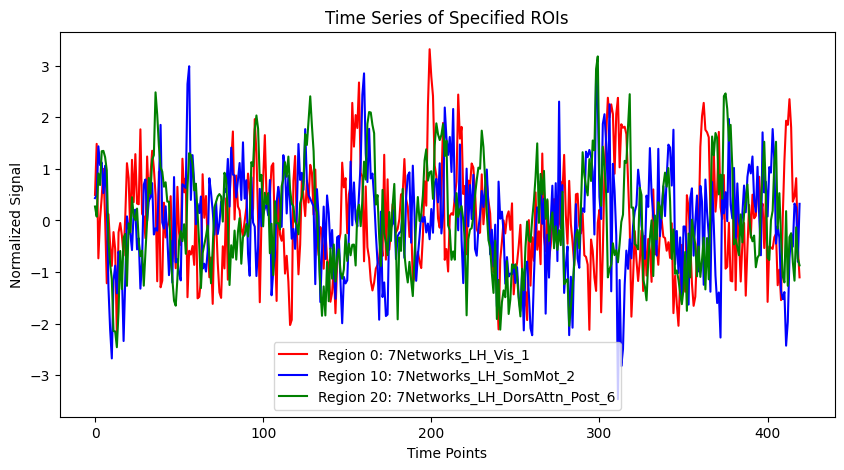

In [16]:
import matplotlib.pyplot as plt
colors = ['red', 'blue', 'green']

# Plotting the time series of the specified regions
plt.figure(figsize=(10, 5))
# print(time_series.shape)
for i, ts in enumerate(roi_indices):
    # print(i)
    # print(len(roi_indices))
    # print(roi_indices[i], roi_labels[i])
    color = colors[i % len(colors)]
    plt.plot(time_series.T[ts], label=f'Region {roi_indices[i]}: {roi_labels[i]}', color=color)
plt.title('Time Series of Specified ROIs')
plt.xlabel('Time Points')
plt.ylabel('Normalized Signal')
plt.legend()
plt.show()


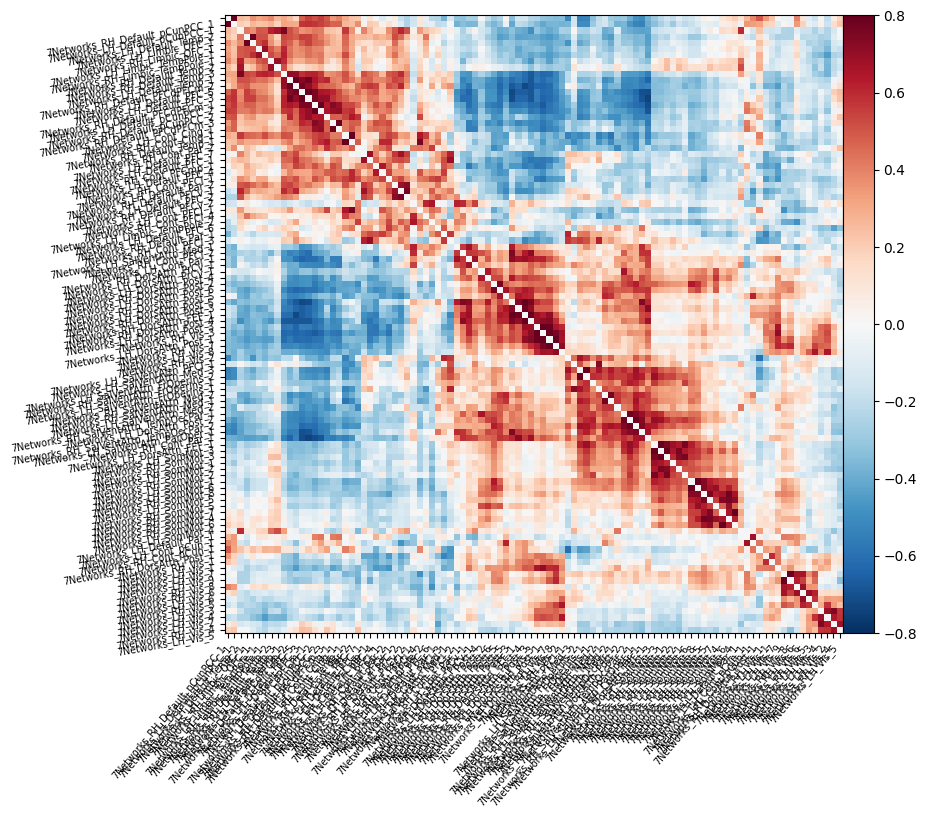

In [17]:
from nilearn.connectome import ConnectivityMeasure
import numpy as np
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

# Plot correlation matrix - note: matrix is ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(8,8), labels=atlas_labels,
                     vmax=0.8, vmin=-0.8, reorder=True);

In [18]:
import glob
import seaborn as sns
# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community


/lustre06/project/6049200/mina94/.venv/lib/python3.11/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [19]:
G = nx.Graph()
print('shape of correlation matrix: ', correlation_matrix.shape)
# Add nodes to the graph
num_nodes = correlation_matrix.shape[0]
G.add_nodes_from(range(num_nodes))
print(f"Graph G with {num_nodes} nodes was built")


shape of correlation matrix:  (100, 100)
Graph G with 100 nodes was built


In [20]:
# Add edges based on correlation matrix
threshold = 0.05  # Adjust this threshold as needed
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        correlation = correlation_matrix[i, j]
        if abs(correlation) >= threshold:
            G.add_edge(i, j, weight=correlation)


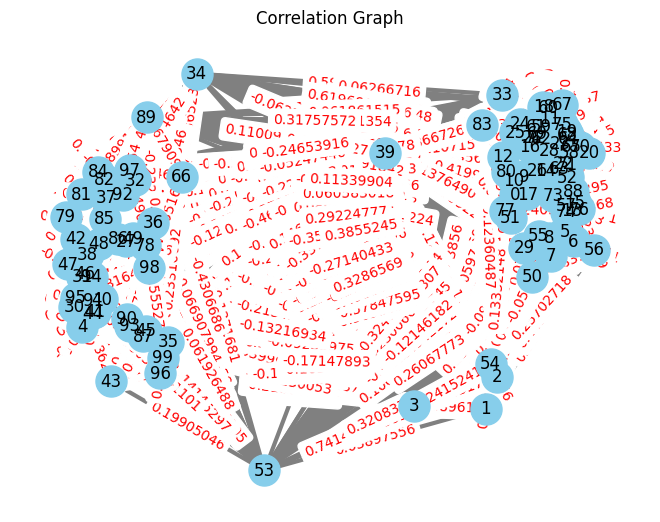

In [21]:
# Draw the graph
pos = nx.spring_layout(G)  # Layout algorithm
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray', width=3, font_size=12, font_color='black')

# Draw edge labels (correlation values)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Show the graph
plt.title("Correlation Graph")
plt.show()

In [22]:
# Creating a graph
# G = nx.from_numpy_array(matrix)

# Removing self-loops
G.remove_edges_from(list(nx.selfloop_edges(G)))

In [23]:

# Compute degree centrality
degree_centralities = nx.degree_centrality(G)
betweenness_centralities = nx.betweenness_centrality(G)

# Compute eigenvector centrality
eigenvector_centralities = nx.eigenvector_centrality(G)


# Print degree centrality for each node
for node, centrality in degree_centralities.items():
    print(f"Node {node}: Degree Centrality = {centrality},  Betweenness Centrality = {betweenness_centralities[node]},  Eigenvector Centrality = {eigenvector_centralities[node]}")

Node 0: Degree Centrality = 0.8484848484848485,  Betweenness Centrality = 0.0010877339989224005,  Eigenvector Centrality = 0.09601633737286006
Node 1: Degree Centrality = 0.8686868686868687,  Betweenness Centrality = 0.0012640901210282318,  Eigenvector Centrality = 0.09785482473987102
Node 2: Degree Centrality = 0.8282828282828284,  Betweenness Centrality = 0.001175125293724069,  Eigenvector Centrality = 0.0931762446100555
Node 3: Degree Centrality = 0.797979797979798,  Betweenness Centrality = 0.0010173494505506114,  Eigenvector Centrality = 0.09020397040394165
Node 4: Degree Centrality = 0.797979797979798,  Betweenness Centrality = 0.0011392874864016504,  Eigenvector Centrality = 0.08954015209248542
Node 5: Degree Centrality = 0.8282828282828284,  Betweenness Centrality = 0.001024407995933227,  Eigenvector Centrality = 0.09377393201692563
Node 6: Degree Centrality = 0.8787878787878789,  Betweenness Centrality = 0.0011725718677608004,  Eigenvector Centrality = 0.09940897305733438
Node

In [24]:
# Compute clustering coefficient
clustering_coefficient = nx.clustering(G)
for node, coefficient in clustering_coefficient.items():
    print(f"Node {node}: clustering_coefficient= {coefficient}")

Node 0: clustering_coefficient= 0.8898450946643718
Node 1: clustering_coefficient= 0.8801641586867305
Node 2: clustering_coefficient= 0.8774465522433003
Node 3: clustering_coefficient= 0.884453099642973
Node 4: clustering_coefficient= 0.872444011684518
Node 5: clustering_coefficient= 0.8903944595001505
Node 6: clustering_coefficient= 0.8901363271852446
Node 7: clustering_coefficient= 0.8999044433827043
Node 8: clustering_coefficient= 0.8878958120531154
Node 9: clustering_coefficient= 0.910960916838084
Node 10: clustering_coefficient= 0.8926332288401254
Node 11: clustering_coefficient= 0.8897596656217346
Node 12: clustering_coefficient= 0.8775438596491228
Node 13: clustering_coefficient= 0.8896214896214896
Node 14: clustering_coefficient= 0.8943820224719101
Node 15: clustering_coefficient= 0.8877939529675252
Node 16: clustering_coefficient= 0.8890414092884923
Node 17: clustering_coefficient= 0.9063535079795242
Node 18: clustering_coefficient= 0.8813186813186813
Node 19: clustering_coeff

In [25]:
clustering_coefficient

{0: 0.8898450946643718,
 1: 0.8801641586867305,
 2: 0.8774465522433003,
 3: 0.884453099642973,
 4: 0.872444011684518,
 5: 0.8903944595001505,
 6: 0.8901363271852446,
 7: 0.8999044433827043,
 8: 0.8878958120531154,
 9: 0.910960916838084,
 10: 0.8926332288401254,
 11: 0.8897596656217346,
 12: 0.8775438596491228,
 13: 0.8896214896214896,
 14: 0.8943820224719101,
 15: 0.8877939529675252,
 16: 0.8890414092884923,
 17: 0.9063535079795242,
 18: 0.8813186813186813,
 19: 0.8899387129724209,
 20: 0.8896321070234113,
 21: 0.8812529219261337,
 22: 0.8967032967032967,
 23: 0.8974358974358975,
 24: 0.8931044866004215,
 25: 0.8903540903540903,
 26: 0.879151061173533,
 27: 0.8873456790123457,
 28: 0.883986562150056,
 29: 0.8824074074074074,
 30: 0.8944099378881988,
 31: 0.8873850868232891,
 32: 0.8904320987654321,
 33: 0.8940533151059467,
 34: 0.8861261261261262,
 35: 0.8857142857142857,
 36: 0.8837625979843226,
 37: 0.8906428734843286,
 38: 0.8888888888888888,
 39: 0.8941649899396378,
 40: 0.88662926

In [26]:
for j in range(num_nodes):
  if abs(correlation_matrix[0,j])>= 0.05 :
     print(j)

1
2
3
4
5
6
7
8
9
10
11
12
13
15
17
19
20
21
22
24
25
26
27
28
30
31
32
33
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
66
67
68
69
70
71
72
73
75
76
78
79
81
82
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [27]:
# Compute shortest path lengths
shortest_path_lengths = dict(nx.shortest_path_length(G))
for node, path_length in shortest_path_lengths.items():
    print(f"Node {node}: shortest path length= {path_length}")

Node 0: shortest path length= {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 15: 1, 17: 1, 19: 1, 20: 1, 21: 1, 22: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 30: 1, 31: 1, 32: 1, 33: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 75: 1, 76: 1, 78: 1, 79: 1, 81: 1, 82: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 14: 2, 16: 2, 18: 2, 23: 2, 34: 2, 35: 2, 62: 2, 63: 2, 64: 2, 65: 2, 77: 2, 80: 2, 29: 2, 74: 2, 83: 2}
Node 1: shortest path length= {1: 0, 0: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 9: 1, 10: 1, 11: 1, 12: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 21: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 30: 1, 31: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1

In [29]:
# Compute clustering coefficient
avg_clustering_coefficient = nx.average_clustering(G)

# Compute average shortest path length
avg_shortest_path_length = nx.average_shortest_path_length(G)

# Compute small-worldness
small_worldness = avg_clustering_coefficient / avg_shortest_path_length
print("Small-worldness:", small_worldness)

Small-worldness: 0.7950127675658134


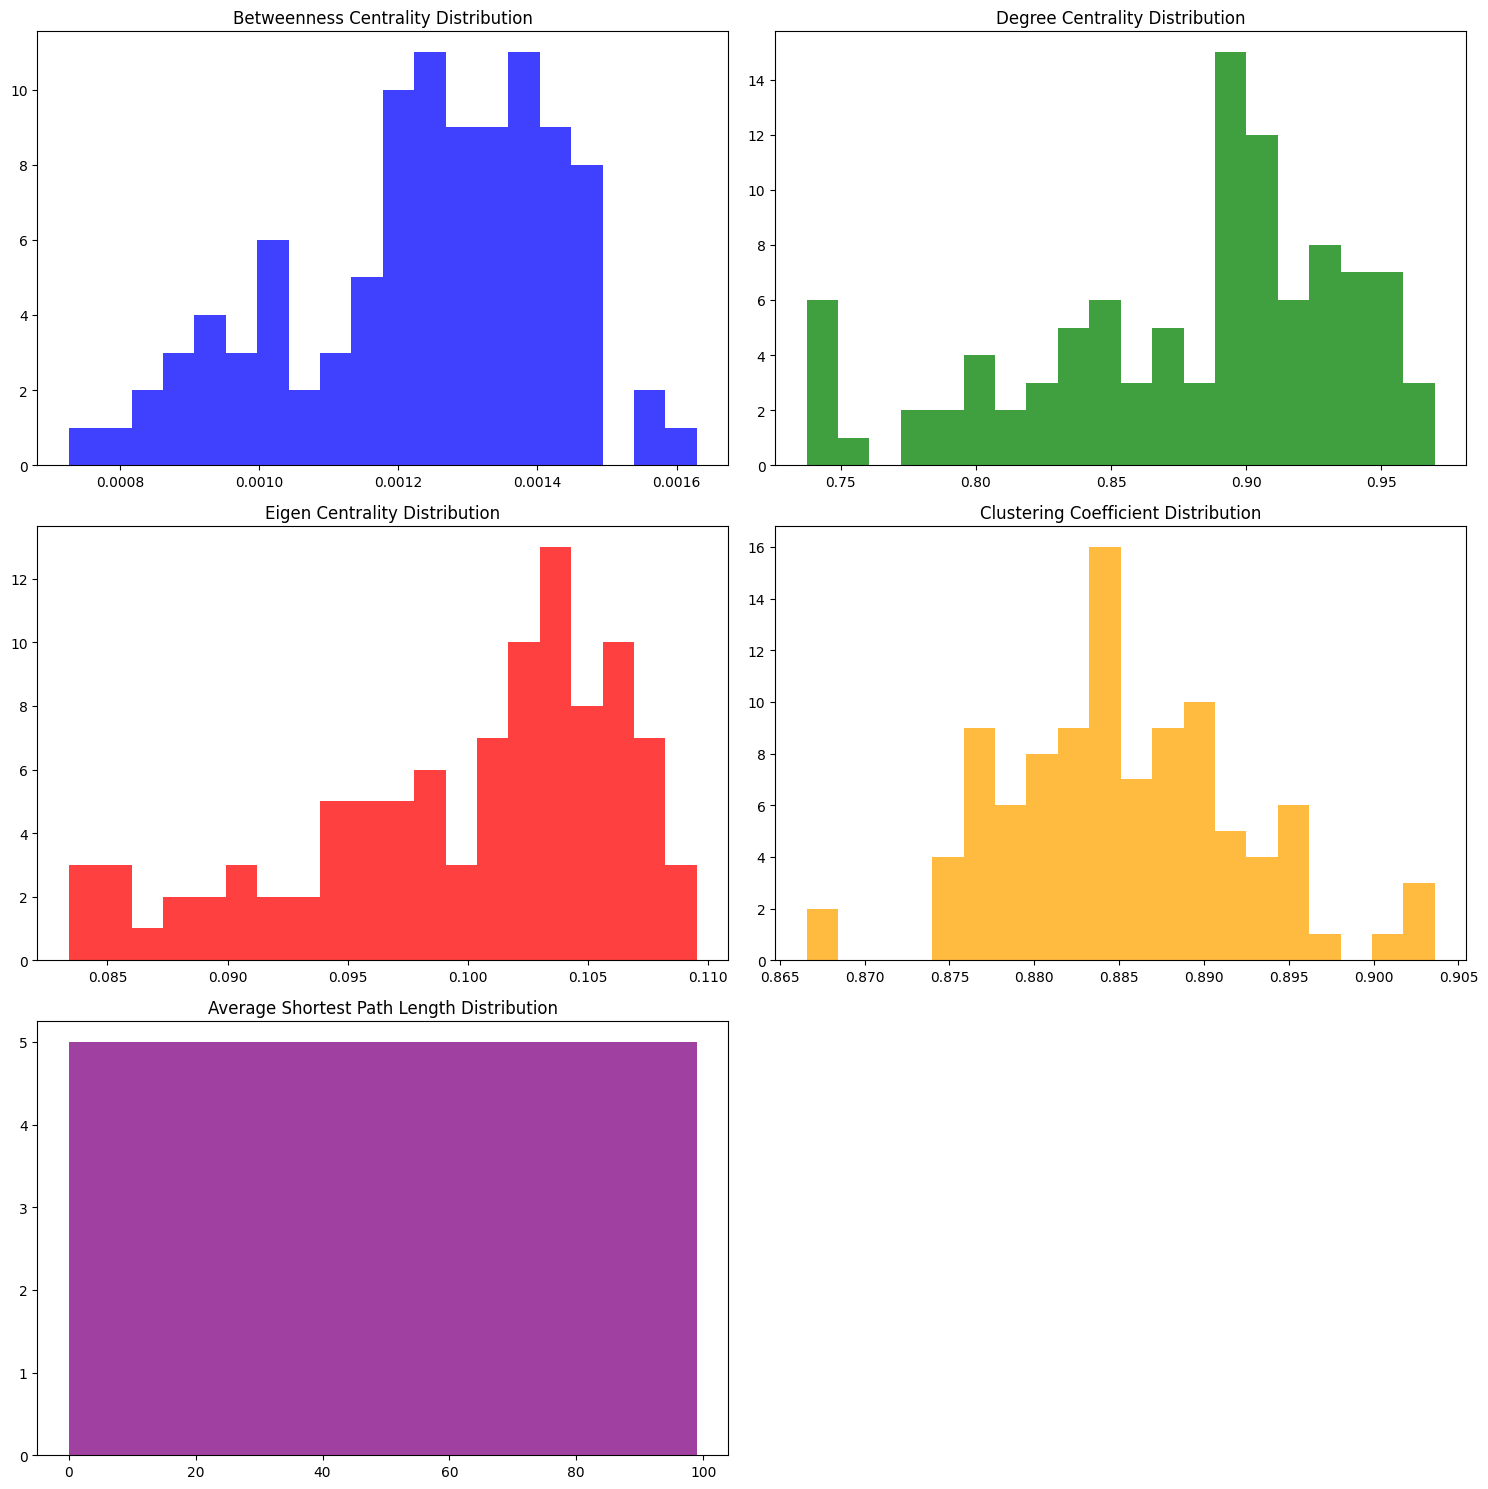

In [ ]:
import matplotlib.pyplot as plt
# Plot distributions
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Betweenness centrality distribution
axs[0, 0].hist(betweenness_centralities.values(), bins=20, alpha=0.75, color='b')
axs[0, 0].set_title('Betweenness Centrality Distribution')

# Degree centrality distribution
axs[0, 1].hist(degree_centralities.values(), bins=20, alpha=0.75, color='g')
axs[0, 1].set_title('Degree Centrality Distribution')

# Eigen centrality distribution
axs[1, 0].hist(eigenvector_centralities.values(), bins=20, alpha=0.75, color='r')
axs[1, 0].set_title('Eigen Centrality Distribution')

# Clustering coefficient distribution
axs[1, 1].hist(clustering_coefficient.values(), bins=20, alpha=0.75, color='orange')
axs[1, 1].set_title('Clustering Coefficient Distribution')

# Shortest path length distribution (average)
axs[2, 0].hist(shortest_path_lengths, bins=20, alpha=0.75, color='purple')
axs[2, 0].set_title('Average Shortest Path Length Distribution')

# Remove empty subplot
fig.delaxes(axs[2, 1])

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

<Axes: >

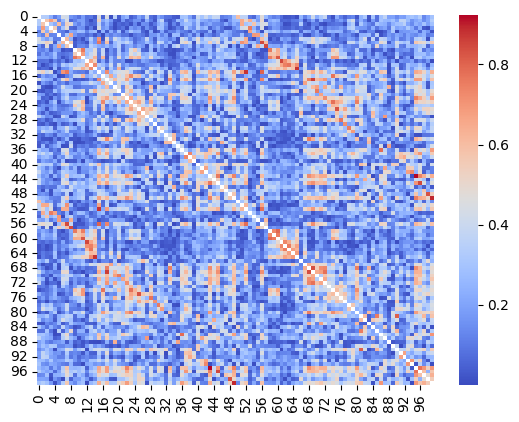

In [ ]:
# matrixdiagNaN=matrix.copy()
# np.fill_diagonal(matrixdiagNaN, np.nan)
# sns.heatmap(matrixdiagNaN,cmap='coolwarm', cbar=True, square=False)

In [ ]:
# # Create graphs for comparison
# matrix2 = matrix.copy()
# matrix3 = matrix.copy()
# # Create sparser graphs
# matrix2[matrix2<=0.005] = 0
# matrix3[matrix3<=0.75] = 0

# st50G = nx.from_numpy_array(matrix2)
# st25G = nx.from_numpy_array(matrix3)

# st50G.remove_edges_from(list(nx.selfloop_edges(st50G)))
# st25G.remove_edges_from(list(nx.selfloop_edges(st25G)))

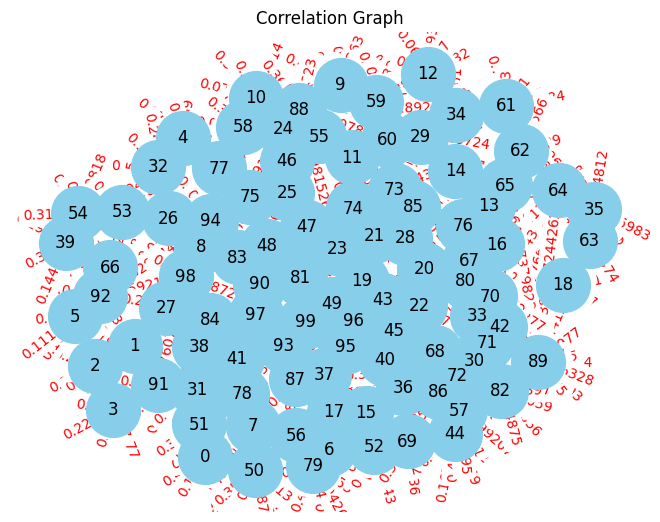

In [ ]:
# # Draw the graph
# pos = nx.spring_layout(G)  # Layout algorithm
# nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray', width=3, font_size=12, font_color='black')

# # Draw edge labels (correlation values)
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# # Show the graph
# plt.title("Correlation Graph")
# plt.show()